# Computer Vision Learner

[`vision.learner`](/vision.learner.html#vision.learner) is the module that defines the [`create_cnn`](/vision.learner.html#create_cnn) method, to easily get a model suitable for transfer learning.

In [ ]:
from fastai.gen_doc.nbdoc import *
from fastai.vision import *
from fastai import *

## Transfer learning

Transfer learning is a technique where you use a model trained on a very large dataset (usually [ImageNet](http://image-net.org/) in computer vision) and then adapt it to your own dataset. The idea is that it has learned to recognize many features on all of this data, and that you will benefit from this knowledge, especially if your dataset is small, compared to starting from a randomly initiliazed model. It has been proved in [this article](https://arxiv.org/abs/1805.08974) on a wide range of tasks that transfer learning nearly always give better results.

In practice, you need to change the last part of your model to be adapted to your own number of classes. Most convolutional models end with a few linear layers (a part will call head). The last convolutional layer will have analyzed features in the image that went through the model, and the job of the head is to convert those in predictions for each of our classes. In transfer learning we will keep all the convolutional layers (called the body or the backbone of the model) with their weights pretrained on ImageNet but will define a new head initiliazed randomly.

Then we will train the model we obtain in two phases: first we freeze the body weights and only train the head (to convert those analyzed features into predictions for our own data), then we unfreeze the layers of the backbone (gradually if necessary) and fine-tune the whole model (possily using differential learning rates).

The [`create_cnn`](/vision.learner.html#create_cnn) factory method helps you to automatically get a pretrained model from a given architecture with a custom head that is suitable for your data.

<h4 id="create_cnn"><code>create_cnn</code> <a href="https://github.com/fastai/fastai/blob/master/fastai/vision/learner.py#L47" class="source_link">[source]</a></h4>

> <code>create_cnn</code>([`data`](/vision.data.html#vision.data):[`DataBunch`](/basic_data.html#DataBunch), `arch`:`Callable`, `cut`:`Union`\[`int`, `Callable`\]=`None`, `pretrained`:`bool`=`True`, `lin_ftrs`:`Optional`\[`Collection`\[`int`\]\]=`None`, `ps`:`Floats`=`0.5`, `custom_head`:`Optional`\[[`Module`](https://pytorch.org/docs/stable/nn.html#torch.nn.Module)\]=`None`, `split_on`:`Union`\[`Callable`, `Collection`\[`ModuleList`\], `NoneType`\]=`None`, `kwargs`:`Any`)

This method creates a [`Learner`](/basic_train.html#Learner) object from the [`data`](/vision.data.html#vision.data) object and model inferred from it with the backbone given in `arch`. Specifically, it will cut the model defined by `arch` (randomly initialized if `pretrained` is False) at the last convolutional layer by default (or as defined in `cut`, see below) and add:
- an [`AdaptiveConcatPool2d`](/layers.html#AdaptiveConcatPool2d) layer,
- a [`Flatten`](/layers.html#Flatten) layer,
- blocks of \[[`nn.BatchNorm1d`](https://pytorch.org/docs/stable/nn.html#torch.nn.BatchNorm1d), [`nn.Dropout`](https://pytorch.org/docs/stable/nn.html#torch.nn.Dropout), [`nn.Linear`](https://pytorch.org/docs/stable/nn.html#torch.nn.Linear), [`nn.ReLU`](https://pytorch.org/docs/stable/nn.html#torch.nn.ReLU)\] layers.

The blocks are defined by the `lin_ftrs` and `ps` arguments. Specifically, the first block will have a number of inputs inferred from the backbone `arch` and the last one will have a number of outputs equal to `data.c` (which contains the number of classes of the data) and the intermediate blocks have a number of inputs/outputs determined by `lin_frts` (of course a block has a number of inputs equal to the number of outputs of the previous block). The default is to have an intermediate hidden size of 512 (which makes two blocks `model_activation` -> 512 -> `n_classes`). If you pass a float then the final dropout layer will have the value `ps`, and the remaining will be `ps/2`. If you pass a list then the values are used for dropout probabilities directly.

Note that the very last block doesn't have a [`nn.ReLU`](https://pytorch.org/docs/stable/nn.html#torch.nn.ReLU) activation, to allow you to use any final activation you want (generally included in the loss function in pytorch). Also, the backbone will be frozen if you choose `pretrained=True` (so only the head will train if you call [`fit`](/basic_train.html#fit)) so that you can immediately start phase one of training as described above.

Alternatively, you can define your own `custom_head` to put on top of the backbone. If you want to specify where to split `arch` you should so in the argument `cut` which can either be the index of a specific layer (the result will not include that layer) or a function that, when passed the model, will return the backbone you want.

The final model obtained by stacking the backbone and the head (custom or defined as we saw) is then separated in groups for gradual unfreezeing or differential learning rates. You can specify of to split the backbone in groups with the optional argument `split_on` (should be a function that returns those groups when given the backbone).  

The `kwargs` will be passed on to [`Learner`](/basic_train.html#Learner), so you can put here anything that [`Learner`](/basic_train.html#Learner) will accept ([`metrics`](/metrics.html#metrics), `loss_func`, `opt_func`...)

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE)
data = ImageDataBunch.from_folder(path)

In [ ]:
learner = create_cnn(data, models.resnet18, metrics=[accuracy])
learner.fit_one_cycle(1,1e-3)

Total time: 00:09
epoch  train_loss  valid_loss  accuracy
1      0.112763    0.066951    0.979882  (00:09)



In [ ]:
learner.save('one_epoch')

### Get predictions

Once you've actually trained your model, you may want to use it on a single image. This is done by using the following method.

In [ ]:
show_doc(ClassificationLearner.predict)

<h4 id="ClassificationLearner.predict"><code>predict</code><a href="https://github.com/fastai/fastai/blob/master/fastai/vision/learner.py#L46" class="source_link">[source]</a></h4>

> <code>predict</code>(`img`:[`Image`](/vision.image.html#Image))

Return prect class, label and probabilities for `img`.  

In [ ]:
img = open_image(learner.data.train_ds.x[0])
learner.predict(img)

('3', tensor(0), tensor([0.9950, 0.0050]))

Here the predict class for our iamge is '3', which corresponds to a label of 0. The probabilities the model found for each class are 99.65% and 0.35% respectively, so its confidence is pretty high.

Note that if you want to load your trained model and use it on inference mode with the previous function, you can create a `cnn_learner` from empty data. Just use the following code:

In [ ]:
empty_data = ImageDataBunch.single_from_classes(path, data.classes, tfms=get_transforms()).normalize(imagenet_stats)
learn = create_cnn(empty_data, models.resnet18)
learn.load('one_epoch')

### Customize your model

You can customize [`create_cnn`](/vision.learner.html#create_cnn) for your own model's default `cut` and `split_on` functions by adding them to the dictionary `model_meta`. The key should be your model and the value should be a dictionary with the keys `cut` and `split_on` (see the source code for examples). The constructor will call [`create_body`](/vision.learner.html#create_body) and [`create_head`](/vision.learner.html#create_head) for you based on `cut`; you can also call them yourself, which is particularly useful for testing.

In [ ]:
show_doc(create_body)

<h4 id="create_body"><code>create_body</code><a href="https://github.com/fastai/fastai/blob/master/fastai/vision/learner.py#L28" class="source_link">[source]</a></h4>

> <code>create_body</code>(`model`:[`Module`](https://pytorch.org/docs/stable/nn.html#torch.nn.Module), `cut`:`Optional`\[`int`\]=`None`, `body_fn`:`Callable`\[[`Module`](https://pytorch.org/docs/stable/nn.html#torch.nn.Module), [`Module`](https://pytorch.org/docs/stable/nn.html#torch.nn.Module)\]=`None`)

Cut off the body of a typically pretrained `model` at `cut` or as specified by `body_fn`.  

In [ ]:
show_doc(create_head, doc_string=False)

<h4 id="create_head"><code>create_head</code><a href="https://github.com/fastai/fastai/blob/master/fastai/vision/learner.py#L33" class="source_link">[source]</a></h4>

> <code>create_head</code>(`nf`:`int`, `nc`:`int`, `lin_ftrs`:`Optional`\[`Collection`\[`int`\]\]=`None`, `ps`:`Floats`=`0.5`)

Model head that takes `nf` features, runs through `lin_ftrs`, and ends with `nc` classes. `ps` is the probability of the dropouts, as documented above in [`create_cnn`](/vision.learner.html#create_cnn).

In [ ]:
show_doc(ClassificationInterpretation)

<h2 id="ClassificationInterpretation"><code>class</code> <code>ClassificationInterpretation</code><a href="https://github.com/fastai/fastai/blob/master/fastai/vision/learner.py#L73" class="source_link">[source]</a></h2>

> <code>ClassificationInterpretation</code>(`data`:[`DataBunch`](/basic_data.html#DataBunch), `probs`:`Tensor`, `y_true`:`Tensor`, `losses`:`Tensor`, `sigmoid`:`bool`=`None`)

Interpretation methods for classification models.  

This provides a confusion matrix and visualization of the most incorrect images. Pass in your [`data`](/vision.data.html#vision.data), calculated `preds`, actual `y`, and your `losses`, and then use the methods below to view the model interpretation results. For instance:

In [ ]:
learn = create_cnn(data, models.resnet18)
learn.fit(1)
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(data, preds, y, losses)

The following fatory method gives a more convenient way to create an instance of this class:

In [ ]:
show_doc(ClassificationInterpretation.from_learner)

<h4 id="ClassificationInterpretation.from_learner"><code>from_learner</code><a href="https://github.com/fastai/fastai/blob/master/fastai/vision/learner.py#L80" class="source_link">[source]</a></h4>

> <code>from_learner</code>(`learn`:[`Learner`](/basic_train.html#Learner), `sigmoid`:`bool`=`None`, `tta`=`False`)

Create an instance of [`ClassificationInterpretation`](/vision.learner.html#ClassificationInterpretation). `tta` indicates if we want to use Test Time Augmentation.  

In [ ]:
jekyll_warn('In both those methods `sigmoid` is a deprecated argument and will be removed in a future version.')

<div markdown="span" class="alert alert-danger" role="alert"><i class="fa fa-danger-circle"></i> <b>Warning: </b>In both those methods `sigmoid` is a deprecated argument and will be removed in a future version.</div>

In [ ]:
show_doc(ClassificationInterpretation.plot_top_losses)

<h4 id="ClassificationInterpretation.plot_top_losses"><code>plot_top_losses</code><a href="https://github.com/fastai/fastai/blob/master/fastai/vision/learner.py#L90" class="source_link">[source]</a></h4>

> <code>plot_top_losses</code>(`k`, `largest`=`True`, `figsize`=`(12, 12)`)

Show images in `top_losses` along with their prediction, actual, loss, and probability of predicted class.  

The `k` items are arranged as a square, so it will look best if `k` is a square number (4, 9, 16, etc). The title of each image shows: prediction, actual, loss, probability of actual class.

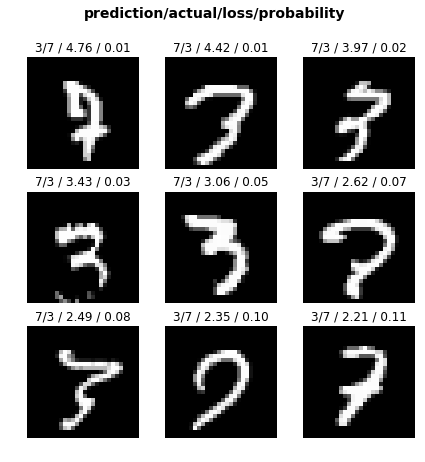

In [ ]:
interp.plot_top_losses(9, figsize=(7,7))

In [ ]:
show_doc(ClassificationInterpretation.top_losses)

<h4 id="ClassificationInterpretation.top_losses"><code>top_losses</code><a href="https://github.com/fastai/fastai/blob/master/fastai/vision/learner.py#L86" class="source_link">[source]</a></h4>

> <code>top_losses</code>(`k`:`int`=`None`, `largest`=`True`)

`k` largest(/smallest) losses and indexes, defaulting to all losses (sorted by `largest`).  

Returns tuple of *(losses,indices)*.

In [ ]:
interp.top_losses(9)

(tensor([4.7578, 4.4174, 3.9698, 3.4310, 3.0567, 2.6207, 2.4914, 2.3518, 2.2122]),
 tensor([1929,    3,   75,  481,  488, 1695,  166, 1336, 1065]))

In [ ]:
show_doc(ClassificationInterpretation.plot_confusion_matrix)

<h4 id="ClassificationInterpretation.plot_confusion_matrix"><code>plot_confusion_matrix</code><a href="https://github.com/fastai/fastai/blob/master/fastai/vision/learner.py#L108" class="source_link">[source]</a></h4>

> <code>plot_confusion_matrix</code>(`normalize`:`bool`=`False`, `title`:`str`=`'Confusion matrix'`, `cmap`:`Any`=`'Blues'`, `norm_dec`:`int`=`2`, `kwargs`)

Plot the confusion matrix, passing `kawrgs` to `plt.figure`.  

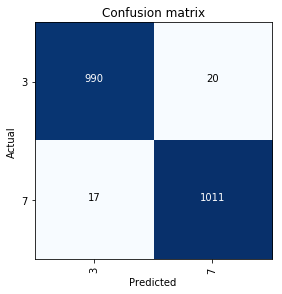

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
show_doc(ClassificationInterpretation.confusion_matrix)

<h4 id="ClassificationInterpretation.confusion_matrix"><code>confusion_matrix</code><a href="https://github.com/fastai/fastai/blob/master/fastai/vision/learner.py#L102" class="source_link">[source]</a></h4>

> <code>confusion_matrix</code>()

Confusion matrix as an `np.ndarray`.  

In [ ]:
interp.confusion_matrix()

array([[ 990,   20],
       [  17, 1011]])

#### Working with large dataset

When working with large datasets, memory problem can arise when computing confusion matrix. For example, an error can look like this:

In this case it is possible to force ClassificationInterpretation class to compute confusion matrix for data slices and then aggregate the result by specifying slice_size parameter. 

In [ ]:
interp.confusion_matrix(slice_size=10)

array([[ 990,   20],
       [  17, 1011]])

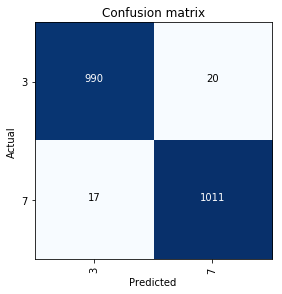

In [ ]:
interp.plot_confusion_matrix(slice_size=10)

In [ ]:
interp.most_confused(slice_size=10)

[('3', '7', 14), ('7', '3', 12)]

In [ ]:
show_doc(ClassificationLearner, doc_string=False)

<h2 id="ClassificationLearner"><code>class</code> <code>ClassificationLearner</code><a href="https://github.com/fastai/fastai/blob/master/fastai/vision/learner.py#L45" class="source_link">[source]</a></h2>

> <code>ClassificationLearner</code>(`data`:[`DataBunch`](/basic_data.html#DataBunch), `model`:[`Module`](https://pytorch.org/docs/stable/nn.html#torch.nn.Module), `opt_func`:`Callable`=`'Adam'`, `loss_func`:`Callable`=`None`, `metrics`:`Collection`\[`Callable`\]=`None`, `true_wd`:`bool`=`True`, `bn_wd`:`bool`=`True`, `wd`:`Floats`=`0.01`, `train_bn`:`bool`=`True`, `path`:`str`=`None`, `model_dir`:`str`=`'models'`, `callback_fns`:`Collection`\[`Callable`\]=`None`, `callbacks`:`Collection`\[[`Callback`](/callback.html#Callback)\]=`<factory>`, `layer_groups`:`ModuleList`=`None`) :: [`Learner`](/basic_train.html#Learner)

## Undocumented Methods - Methods moved below this line will intentionally be hidden

In [ ]:
show_doc(ClassificationInterpretation.from_learner)

<h4 id="ClassificationInterpretation.from_learner"><code>from_learner</code><a href="https://github.com/fastai/fastai/blob/master/fastai/vision/learner.py#L80" class="source_link">[source]</a></h4>

> <code>from_learner</code>(`learn`:[`Learner`](/basic_train.html#Learner), `sigmoid`:`bool`=`None`, `tta`=`False`)

Create an instance of [`ClassificationInterpretation`](/vision.learner.html#ClassificationInterpretation). `tta` indicates if we want to use Test Time Augmentation.  

## New Methods - Please document or move to the undocumented section

In [ ]:
show_doc(ClassificationInterpretation.most_confused)

<h4 id="ClassificationInterpretation.most_confused"><code>most_confused</code><a href="https://github.com/fastai/fastai/blob/master/fastai/vision/learner.py#L128" class="source_link">[source]</a></h4>

> <code>most_confused</code>(`min_val`:`int`=`1`) → `Collection`\[`Tuple`\[`str`, `str`, `int`\]\]

Sorted descending list of largest non-diagonal entries of confusion matrix  